# Survival Analysis - LightGBM + SHAP

In [1]:
!pip install -U sentence-transformers > /dev/null 2>&1
!pip install xgboost > /dev/null 2>&1
!pip install scikit-learn==1.4.2 scikit-survival==0.23.1 > /dev/null 2>&1
!pip install torchtuples > /dev/null 2>&1
!pip install pycox > /dev/null 2>&1
!pip install numpy==1.21.5  > /dev/null 2>&1
!pip install interpret-core  > /dev/null 2>&1
!pip install lightgbm > /dev/null 2>&1
!pip install shap > /dev/null 2>&1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import kagglehub
import contextlib
import logging

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

import lightgbm as lgb
import shap



In [8]:
# Life Expectancy dataset
life_exp_path = kagglehub.dataset_download("kumarajarshi/life-expectancy-who")
life_exp_file = os.path.join(life_exp_path, "Life Expectancy Data.csv")
life_exp_df = pd.read_csv(life_exp_file)
print("Life Expectancy Sample:")
print(life_exp_df.head())

# Heart Failure dataset (not used in LightGBM, but kept for context)
heart_path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
heart_file = os.path.join(heart_path, "heart.csv")
heart_df = pd.read_csv(heart_file)
print("Heart Failure Sample:")
print(heart_df.head())

# Age Dataset
age_path = kagglehub.dataset_download("imoore/age-dataset")
age_file = os.path.join(age_path, "AgeDataset-V1.csv")
age_df = pd.read_csv(age_file)
print("Age Dataset Sample:")
print(age_df.head())

# World important events Dataset
events_path = kagglehub.dataset_download("saketk511/world-important-events-ancient-to-modern")
events_file = os.path.join(events_path, "World Important Dates.csv")
world_events_df = pd.read_csv(events_file)
print("World Important Events Sample:")
print(world_events_df.head())



Life Expectancy Sample:
       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GD

In [5]:
# -------------------------- Data Cleaning --------------------------
# Life Expectancy: drop rows with missing target and fill missing values
life_exp_df = life_exp_df.dropna(subset=['Life expectancy '])
life_exp_df['Alcohol'] = life_exp_df.groupby(['Country', 'Year'])['Alcohol'].transform(
    lambda x: x.fillna(x.median()))
life_exp_df['Alcohol'] = life_exp_df['Alcohol'].fillna(life_exp_df['Alcohol'].median())
life_exp_df['GDP'] = life_exp_df.groupby('Country')['GDP'].transform(
    lambda x: x.fillna(x.median()))
life_exp_df['GDP'] = life_exp_df['GDP'].fillna(life_exp_df['GDP'].median())
life_exp_df = life_exp_df.drop(columns=[
    'Hepatitis B', 'Population', 'Income composition of resources',
    ' thinness  1-19 years', ' thinness 5-9 years'
])
life_exp_df = life_exp_df.fillna(method='ffill').fillna(method='bfill')

# Heart Failure: simple one-hot encoding for some categorical features
heart_df = pd.get_dummies(heart_df, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=True)
heart_df['ExerciseAngina'] = heart_df['ExerciseAngina'].map({'Y': 1, 'N': 0})

# Age Dataset: drop rows with missing 'Death year' or 'Age of death'
age_df = age_df.dropna(subset=['Death year', 'Age of death'])
for col in ['Gender', 'Country', 'Occupation', 'Short description']:
    age_df[col] = age_df[col].fillna('Unknown')
age_df['Country'] = age_df['Country'].str.split(';').str[0]
occupation_counts = age_df['Occupation'].value_counts()
age_df['Occupation'] = np.where(
    age_df['Occupation'].isin(occupation_counts[occupation_counts >= 1000].index),
    age_df['Occupation'],
    'Other'
)
age_df['Gender'] = np.where(age_df['Gender'] == 'Male', 1,
                            np.where(age_df['Gender'] == 'Female', 0, 0.5))
age_df = age_df.drop(columns=['Manner of death'])

# Print final missing values summary
print("\nFinal Missing Values:")
print("Life Expectancy:\n", life_exp_df.isnull().sum())
print("Heart Failure:\n", heart_df.isnull().sum())
print("Age Dataset:\n", age_df.isnull().sum())


/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctio


Final Missing Values:
Life Expectancy:
 Country                   0
Year                      0
Status                    0
Life expectancy           0
Adult Mortality           0
infant deaths             0
Alcohol                   0
percentage expenditure    0
Measles                   0
 BMI                      0
under-five deaths         0
Polio                     0
Total expenditure         0
Diphtheria                0
 HIV/AIDS                 0
GDP                       0
Schooling                 0
dtype: int64
Heart Failure:
 Age                  0
Sex                  0
RestingBP            0
Cholesterol          0
FastingBS            0
MaxHR                0
ExerciseAngina       0
Oldpeak              0
HeartDisease         0
ChestPainType_ATA    0
ChestPainType_NAP    0
ChestPainType_TA     0
RestingECG_Normal    0
RestingECG_ST        0
ST_Slope_Flat        0
ST_Slope_Up          0
dtype: int64
Age Dataset:
 Id                   0
Name                 0
Short descrip

In [25]:
def enhanced_feature_engineering(df, life_exp_df, top_tfidf=20):
    """
    Performs cleaning and enhanced synthetic feature engineering.
    - Normalizes key synthetic features.
    - Merges country-level data and scales them.
    - Computes TF-IDF features from 'Occupation' + 'Short description' and retains only the top `top_tfidf` features.
    - Creates several interaction terms.
    """
    # Basic cleaning
    for col in ['Gender', 'Country', 'Occupation', 'Short description']:
        df[col] = df[col].fillna('Unknown')
    df['Country'] = df['Country'].str.split(';').str[0]
    occupation_counts = df['Occupation'].value_counts()
    df['Occupation'] = np.where(df['Occupation'].isin(occupation_counts[occupation_counts >= 1000].index),
                                df['Occupation'], 'Other')
    df['Gender'] = np.where(df['Gender'] == 'Male', 1, np.where(df['Gender'] == 'Female', 0, 0.5))
    
    # 1. Stress Score (normalized)
    stress_map = {
        'Politician': 9, 'Military personnel': 8, 'Journalist': 7,
        'Businessperson': 6, 'Artist': 5, 'Teacher': 4, 
        'Researcher': 3, 'Other': 5, 'Unknown': 5
    }
    df['stress_score_raw'] = df['Occupation'].map(stress_map).fillna(5).astype('float32')
    df['stress_score'] = df['stress_score_raw'] / 9.0

    # 2. BMI from Country (using median and standardizing)
    country_bmi = life_exp_df.groupby('Country')[' BMI '].median().to_dict()
    df['avg_bmi_raw'] = df['Country'].map(country_bmi).fillna(25).astype('float32')
    df['avg_bmi'] = (df['avg_bmi_raw'] - df['avg_bmi_raw'].mean()) / df['avg_bmi_raw'].std()

    # 3. Heart Disease Risk (Composite Score)
    df['heart_disease_risk'] = (0.4 * df['Gender'] +
                                0.3 * df['stress_score'] +
                                0.3 * df['avg_bmi']).astype('float32')

    # 4. Smoking Prevalence (logistic transformation)
    birth_years = df['Birth year'].to_numpy()
    df['smoking_prev'] = (1 / (1 + np.exp((birth_years - 1950) / 10))).astype('float32')
    df['smoking_prev'] = np.clip(df['smoking_prev'], 0.1, 0.6)

    # 5. Country-Level Features: merge and scale
    life_exp_filtered = (life_exp_df[['Country', 'Alcohol', 'GDP', 'Schooling']]
                         .sort_values('Country')
                         .groupby('Country').median()
                         .add_prefix('country_'))
    df['Country'] = df['Country'].astype('category')
    df = df.join(life_exp_filtered, on='Country', how='left')
    for col in ['country_Alcohol', 'country_GDP', 'country_Schooling']:
        df[col] = df[col].fillna(df[col].median())
        df[col + '_scaled'] = (df[col] - df[col].mean()) / df[col].std()

    # 6. Text Features: TF-IDF on (Occupation + Short description)
    from sklearn.feature_extraction.text import TfidfVectorizer
    text_data = df['Occupation'] + " " + df['Short description'].fillna('')
    tfidf = TfidfVectorizer(max_features=100, ngram_range=(1,2), stop_words='english')
    text_features = tfidf.fit_transform(text_data)
    text_df = pd.DataFrame(
        text_features.toarray(),
        columns=[f"tfidf_{i}" for i in range(text_features.shape[1])],
        index=df.index
    )
    # Select top TF-IDF features by absolute Pearson correlation with 'Age of death'
    target = df['Age of death']
    correlations = text_df.apply(lambda col: col.corr(target))
    top_tfidf_features = correlations.abs().sort_values(ascending=False).head(top_tfidf).index
    text_df = text_df[top_tfidf_features]
    
    # 7. Concatenate TF-IDF features
    df = pd.concat([df, text_df], axis=1)

    # 8. Additional Interaction Terms
    df['stress_x_smoking'] = (df['stress_score'] * df['smoking_prev']).astype('float32')
    df['stress_x_avg_bmi'] = (df['stress_score'] * df['avg_bmi']).astype('float32')
    df['avg_bmi_x_smoking'] = (df['avg_bmi'] * df['smoking_prev']).astype('float32')
    df['heart_x_stress'] = (df['heart_disease_risk'] * df['stress_score']).astype('float32')
    df['heart_x_avg_bmi'] = (df['heart_disease_risk'] * df['avg_bmi']).astype('float32')
    
    return df

In [26]:
# -------------------------- Global Batch Settings --------------------------
BATCH_SIZE = 50000
N_ITERATIONS = 5
BASE_RANDOM_STATE = 42

# %% [code]
# Function to sample a processed mini-batch from age_df
def get_processed_batch(random_seed):
    batch_df = age_df.sample(n=BATCH_SIZE, random_state=random_seed).copy()
    processed_batch = enhanced_feature_engineering(batch_df, life_exp_df, top_tfidf=20)
    return processed_batch


In [46]:
def final_lgbm_model(df):
    """
    Trains a final LightGBM regressor using the tuned hyperparameters on the processed DataFrame,
    evaluates it on a hold-out validation set, and computes SHAP feature importances.
    Returns the trained model, RMSE, MAE, full SHAP importances, and the top 10 features.
    """
    # Set environment variable and logger level to help suppress LightGBM messages.
    os.environ["LIGHTGBM_VERBOSE"] = "-1"
    logging.getLogger("lightgbm").setLevel(logging.ERROR)

    # Define feature set including enhanced synthetic features, interaction terms, and TF-IDF features.
    feature_list = ['stress_score', 'avg_bmi', 'heart_disease_risk', 
                    'smoking_prev', 'country_Alcohol', 'country_GDP', 'stress_x_smoking',
                    'stress_x_avg_bmi', 'avg_bmi_x_smoking', 'heart_x_stress', 'heart_x_avg_bmi']
    tfidf_cols = [col for col in df.columns if col.startswith('tfidf_')]
    features = feature_list + tfidf_cols

    X = df[features]
    y = df['Age of death']
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=BASE_RANDOM_STATE)
    
    # Tuned hyperparameters
    best_params = {
        'learning_rate': 0.05,
        'max_depth': 4,
        'min_child_samples': 20,
        'n_estimators': 200,
        'num_leaves': 31
    }
    
    # Pass verbose=-1 in the constructor to suppress output.
    final_model = lgb.LGBMRegressor(random_state=BASE_RANDOM_STATE, verbose=-1, **best_params)
    
    # Suppress output during training by redirecting stdout and stderr.
    with open(os.devnull, 'w') as devnull, \
         contextlib.redirect_stdout(devnull), \
         contextlib.redirect_stderr(devnull):
        final_model.fit(X_train, y_train)
    
    y_pred = final_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    
    # Compute SHAP values and importance
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_val)
    shap_importance = np.abs(shap_values).mean(axis=0)
    shap_importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'shap_importance': shap_importance
    }).sort_values('shap_importance', ascending=False)
    
    top_features = shap_importance_df.head(10)
    
    return final_model, rmse, mae, shap_importance_df, top_features


In [47]:
processed_batch = get_processed_batch(BASE_RANDOM_STATE)
final_model, final_rmse, final_mae, final_shap_importance, top_features = final_lgbm_model(processed_batch)

print("Final LightGBM Model Performance:")
print("Validation RMSE:", final_rmse)
print("Validation MAE:", final_mae)
print("\nTop 10 Features by SHAP Importance:")
print(top_features)
print("\nFull SHAP Feature Importance:")
print(final_shap_importance)


Final LightGBM Model Performance:
Validation RMSE: 15.6967970814296
Validation MAE: 12.326934081183015

Top 10 Features by SHAP Importance:
              feature  shap_importance
3        smoking_prev         1.642481
11           tfidf_97         0.659470
4     country_Alcohol         0.655472
10    heart_x_avg_bmi         0.647854
7    stress_x_avg_bmi         0.548329
12           tfidf_61         0.291663
5         country_GDP         0.264087
17            tfidf_2         0.252178
15           tfidf_82         0.185099
8   avg_bmi_x_smoking         0.128373

Full SHAP Feature Importance:
               feature  shap_importance
3         smoking_prev         1.642481
11            tfidf_97         0.659470
4      country_Alcohol         0.655472
10     heart_x_avg_bmi         0.647854
7     stress_x_avg_bmi         0.548329
12            tfidf_61         0.291663
5          country_GDP         0.264087
17             tfidf_2         0.252178
15            tfidf_82         0.185099


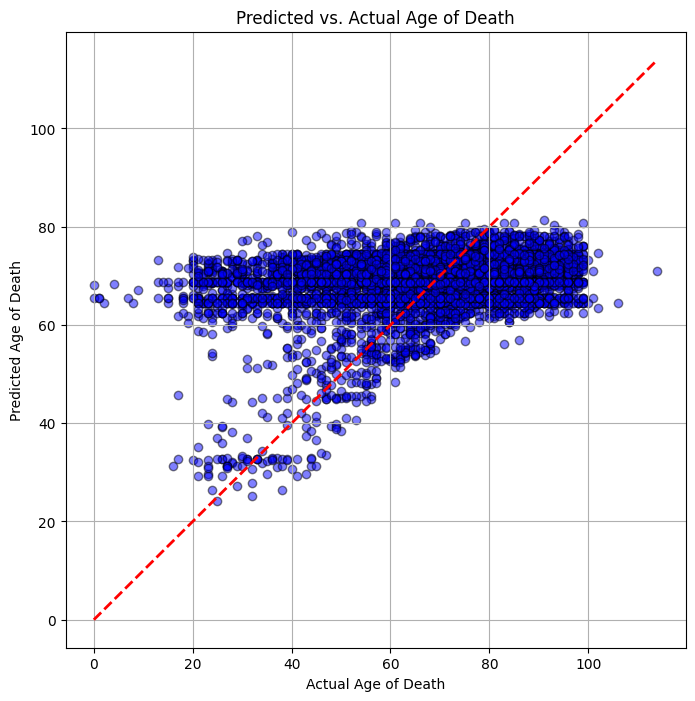

In [48]:
# Extract the feature set from the processed batch (same as used in final_lgbm_model)
feature_list = ['stress_score', 'avg_bmi', 'heart_disease_risk', 
                'smoking_prev', 'country_Alcohol', 'country_GDP', 
                'stress_x_smoking', 'stress_x_avg_bmi', 'avg_bmi_x_smoking', 
                'heart_x_stress', 'heart_x_avg_bmi']
tfidf_cols = [col for col in processed_batch.columns if col.startswith('tfidf_')]
features = feature_list + tfidf_cols

# Split the processed batch into training and validation sets
X = processed_batch[features]
y = processed_batch['Age of death']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=BASE_RANDOM_STATE)

# Get predictions on the validation set using your final model (final_model was returned from final_lgbm_model)
y_pred = final_model.predict(X_val)

# Plot predicted vs. actual ages
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred, alpha=0.5, color='blue', edgecolor='k')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel("Actual Age of Death")
plt.ylabel("Predicted Age of Death")
plt.title("Predicted vs. Actual Age of Death")
plt.grid(True)
plt.show()
